### Geographically Neural Network Weighted Regression (GNNWR)

This notebook will explore using the GNNWR model [https://arxiv.org/abs/2202.04358]

In [1]:
import pandas as pd
import torch.nn as nn
from gnnwr import models,datasets,utils
import matplotlib.pyplot as plt

#### Load the dataset to be trained

In [2]:
hdb_data = pd.read_csv('./data/train-test/data_gnnwr.csv')
hdb_data.head()

,storey_range,floor_area_sqm,remaining_lease,resale_price,latitude,longitude,sora,bto_supply_within_4km,distance2cbd,town_BEDOK,...,flat_model_New Generation,flat_model_Others,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,poi_vector_average
0,2,60.0,70.0,12.449019,1.375097,103.837619,0.129019,6587,9.764087,0,...,0,0,0,0,0,0,0,0,0,0.218139
1,0,68.0,65.0,12.524526,1.373922,103.855621,0.129019,23252,9.515643,0,...,1,0,0,0,0,0,0,0,0,0.237577
2,0,69.0,64.0,12.560244,1.373552,103.838169,0.129019,4941,9.585589,0,...,1,0,0,0,0,0,0,0,0,0.218139
3,0,68.0,63.0,12.577636,1.367761,103.855357,0.129019,20043,8.833708,0,...,1,0,0,0,0,0,0,0,0,0.225553
4,2,68.0,64.0,12.577636,1.371626,103.857736,0.129019,26356,9.275781,0,...,1,0,0,0,0,0,0,0,0,0.237577


We need to ensure that the column names are interpretable by the model; this involves removing whitespaces and replacing slashes with underscores.

In addition, due to the sheer number of columns we are working with and the limitations in memory to train the model, we will exclude the `town` one-hot encoded variables.

In [3]:
hdb_data.columns = hdb_data.columns.str.replace(' ', '_')
hdb_data.columns = hdb_data.columns.str.replace('/', '_')
hdb_data.columns

x_cols = list(hdb_data.columns)
x_cols.remove('resale_price')
x_cols.remove('latitude')
x_cols.remove('longitude')

# remove town
x_cols = [col for col in x_cols if 'town' not in col]

y_col = ['resale_price']
spat_cols = ['latitude', 'longitude']
print(x_cols)

['storey_range', 'floor_area_sqm', 'remaining_lease', 'sora', 'bto_supply_within_4km', 'distance2cbd', 'flat_model_Apartment', 'flat_model_DBSS', 'flat_model_Improved', 'flat_model_Maisonette', 'flat_model_Model_A', 'flat_model_Model_A2', 'flat_model_New_Generation', 'flat_model_Others', 'flat_model_Premium_Apartment', 'flat_model_Premium_Apartment_Loft', 'flat_model_Simplified', 'flat_model_Standard', 'flat_model_Terrace', 'flat_model_Type_S1', 'flat_model_Type_S2', 'poi_vector_average']


As mentioned above, we do not have sufficient memory and GPU to run this model (we faced many issues feeding the entire dataset, which has over 200,000 rows, into the model). To resolve this, we used `pandas.df.sample` to sample out a portion of the dataset and used it to train the model. We chose 10k samples in this case. 

In [4]:
hdb_data_sample = hdb_data.sample(n=10000)

train_set, val_set, test_set = datasets.init_dataset(data=hdb_data_sample,
                                                      test_ratio=0.2, valid_ratio=0.1,
                                                      x_column=x_cols,
                                                      y_column=y_col,
                                                      spatial_column=spat_cols)



x_min:[0.00000000e+00 3.10000000e+01 4.27500000e+01 8.45272727e-02
 6.36000000e+02 7.21958596e-01 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00];  x_max:[1.60000000e+01 2.41000000e+02 9.65000000e+01 3.75367619e+00
 9.73240000e+04 1.95718094e+01 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 3.63980117e-01]
y_min:[12.06104687];  y_max:[14.19394699]


In [5]:
gnnwr = models.GNNWR(train_dataset = train_set,
                     valid_dataset = val_set,
                     test_dataset = test_set,
                     dense_layers = [1024, 256, 128],
                     activate_func = nn.ReLU(),
                     start_lr = 0.1,
                     optimizer = "Adadelta",
                     model_name = "GNNWR_VER2",
                     model_save_path = "./gnnwr_models")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/gnnwr/utils.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept = self.__fit.params[0]


In [6]:
gnnwr.add_graph()

Add Graph Successfully


In [7]:
gnnwr.run(max_epoch=120, early_stop=80, print_frequency=10)

  8%|▊         | 10/120 [03:19<36:23, 19.85s/it]


Epoch:  10
learning rate:  0.09821321585546244
Train Loss:  1.9733706124623616
Train R2: -17.50084
Train RMSE: 1.40477
Train AIC: 25349.86504
Train AICc: 25330.06055
Valid Loss:  0.4363400936126709
Valid R2: -2.99518 

Best R2: -0.89248 



 17%|█▋        | 20/120 [06:52<38:51, 23.31s/it]


Epoch:  20
learning rate:  0.09221862584235528
Train Loss:  0.6975122454431322
Train R2: -5.53935
Train RMSE: 0.83517
Train AIC: 17862.02089
Train AICc: 17847.02344
Valid Loss:  0.08797398209571838
Valid R2: 0.19450 

Best R2: 0.35615 



 25%|██▌       | 30/120 [11:07<34:45, 23.18s/it]


Epoch:  30
learning rate:  0.08258081741438394
Train Loss:  0.42301470239957173
Train R2: -2.96587
Train RMSE: 0.65040
Train AIC: 14261.20699
Train AICc: 14247.99902
Valid Loss:  0.13494063913822174
Valid R2: -0.23553 

Best R2: 0.64036 



 33%|███▎      | 40/120 [14:26<26:52, 20.15s/it]


Epoch:  40
learning rate:  0.07024320641103812
Train Loss:  0.2965696026219262
Train R2: -1.78041
Train RMSE: 0.54458
Train AIC: 11704.30729
Train AICc: 11693.67578
Valid Loss:  0.02680044434964657
Valid R2: 0.75461 

Best R2: 0.75461 



 42%|████▏     | 50/120 [17:43<23:02, 19.75s/it]


Epoch:  50
learning rate:  0.056413484158515784
Train Loss:  0.21885076857275432
Train R2: -1.05178
Train RMSE: 0.46781
Train AIC: 9516.28571
Train AICc: 9507.80859
Valid Loss:  0.0625728890299797
Valid R2: 0.42708 

Best R2: 0.75461 



 50%|█████     | 60/120 [21:33<24:03, 24.07s/it]


Epoch:  60
learning rate:  0.042445400228234696
Train Loss:  0.1716485646367073
Train R2: -0.60925
Train RMSE: 0.41430
Train AIC: 7767.11117
Train AICc: 7759.39795
Valid Loss:  0.03601691126823425
Valid R2: 0.67023 

Best R2: 0.77802 



 58%|█████▊    | 70/120 [25:50<26:38, 31.96s/it]


Epoch:  70
learning rate:  0.02970624799665412
Train Loss:  0.1416684913304117
Train R2: -0.32818
Train RMSE: 0.37639
Train AIC: 6385.00318
Train AICc: 6376.53613
Valid Loss:  0.022701306268572807
Valid R2: 0.79214 

Best R2: 0.80132 



 67%|██████▋   | 80/120 [29:45<18:25, 27.65s/it]


Epoch:  80
learning rate:  0.019443024443093933
Train Loss:  0.1241192701127794
Train R2: -0.16365
Train RMSE: 0.35231
Train AIC: 5432.82669
Train AICc: 5425.39990
Valid Loss:  0.024326927959918976
Valid R2: 0.77726 

Best R2: 0.80132 



 75%|███████▌  | 90/120 [33:19<11:27, 22.92s/it]


Epoch:  90
learning rate:  0.012660365397059855
Train Loss:  0.11321866169571876
Train R2: -0.06145
Train RMSE: 0.33648
Train AIC: 4770.98847
Train AICc: 4763.80615
Valid Loss:  0.032545723021030426
Valid R2: 0.70201 

Best R2: 0.81098 



 83%|████████▎ | 100/120 [37:32<08:44, 26.24s/it]


Epoch:  100
learning rate:  0.010022204783542078
Train Loss:  0.1041487692296505
Train R2: 0.02358
Train RMSE: 0.32272
Train AIC: 4169.78303
Train AICc: 4162.86621
Valid Loss:  0.022672493010759354
Valid R2: 0.79241 

Best R2: 0.81098 



 92%|█████████▏| 110/120 [41:22<04:13, 25.30s/it]


Epoch:  110
learning rate:  0.0998002884071386
Train Loss:  0.08216416523688369
Train R2: 0.22969
Train RMSE: 0.28664
Train AIC: 2462.65584
Train AICc: 2456.71973
Valid Loss:  0.020066387951374054
Valid R2: 0.81627 

Best R2: 0.81627 



100%|██████████| 120/120 [45:23<00:00, 22.69s/it]


Epoch:  120
learning rate:  0.09911220285797749
Train Loss:  0.0533617345823182
Train R2: 0.49972
Train RMSE: 0.23100
Train AIC: -645.04692
Train AICc: -650.66272
Valid Loss:  0.02591576613485813
Valid R2: 0.76271 

Best R2: 0.82350 



Best_r2: 0.8234995098388489


In [8]:
gnnwr.result()

--------------------Model Information-----------------
Model Name:           | GNNWR_VER2
independent variable: | ['storey_range', 'floor_area_sqm', 'remaining_lease', 'sora', 'bto_supply_within_4km', 'distance2cbd', 'flat_model_Apartment', 'flat_model_DBSS', 'flat_model_Improved', 'flat_model_Maisonette', 'flat_model_Model_A', 'flat_model_Model_A2', 'flat_model_New_Generation', 'flat_model_Others', 'flat_model_Premium_Apartment', 'flat_model_Premium_Apartment_Loft', 'flat_model_Simplified', 'flat_model_Standard', 'flat_model_Terrace', 'flat_model_Type_S1', 'flat_model_Type_S2', 'poi_vector_average']
dependent variable:   | ['resale_price']

OLS coefficients: 
x0: 0.46554
x1: 2.07724
x2: 0.48681
x3: 0.24189
x4: -0.10730
x5: -0.62414
x6: -0.05492
x7: 0.18758
x8: -0.06334
x9: 0.01485
x10: -0.04362
x11: -0.03997
x12: -0.02820
x13: 0.06075
x14: -0.01388
x15: 0.30479
x16: -0.00545
x17: -0.06188
x18: 0.31436
x19: 0.06838
x20: 0.10984
x21: 0.11498
Intercept: 12.32740

--------------------Resu

#### Plotting loss over epochs

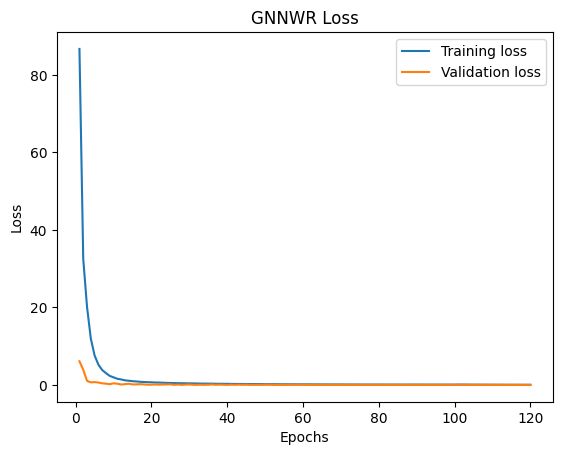

In [25]:
# get loss over epochs
train_loss, valid_loss = gnnwr.getLoss()

# create range of epochs
epochs = range(1, len(train_loss) + 1)

import matplotlib.pyplot as plt

# plot training loss
plt.plot(epochs, train_loss, label='Training loss')

# plot validation loss
plt.plot(epochs, valid_loss, label='Validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GNNWR Loss')
plt.legend()

plt.show()

From the loss plot:

1. **Efficient Learning in Early Epochs**: The rapid decrease in training loss during the initial epochs suggests that the model is efficiently learning from the data. This indicates a good fit of the model’s architecture to the problem at hand, as it is able to quickly reduce errors in predictions.

2. **Stabilization of Model Performance**: The fact that both training and validation losses stabilize after around 20 epochs and show minimal fluctuation thereafter implies that the model reaches its performance capacity relatively early. This could mean that additional training beyond this point does not yield significant improvements and might not be cost-effective.

#### Predicting 2024 data

In [69]:
pred_data = pd.read_csv('./data/train-test/2024-data.csv')
pred_data.head()

,flat_type,block,street_name,storey_range,lease_commence_date,resale_price,address,latitude,longitude,nearest_mrt_station,...,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2,floor_area_sqm,remaining_lease,sora,bto_supply_within_4km,distance2cbd,poi_vector_average
0,1,116,ANG MO KIO AVE 4,2,1978,12.570716,116 ANG MO KIO AVE 4,1.373346,103.836459,Yio Chu Kang MRT Station (1327.32m),...,0,0,0,0,-2.211786,-1.607778,2.175147,-0.970227,-0.563772,-0.375705
1,1,510,ANG MO KIO AVE 8,1,1980,12.683858,510 ANG MO KIO AVE 8,1.373401,103.849073,Ang Mo Kio MRT Station (376.66m),...,0,0,0,0,-2.211786,-1.448652,2.175147,-0.345136,-0.596351,-0.340607
2,2,308B,ANG MO KIO AVE 1,0,2012,13.161584,308B ANG MO KIO AVE 1,1.365266,103.844538,Ang Mo Kio MRT Station (758.33m),...,0,0,0,0,-1.130791,1.012438,2.175147,-0.810390,-0.795211,0.634423
3,2,308B,ANG MO KIO AVE 1,8,2012,13.384728,308B ANG MO KIO AVE 1,1.365266,103.844538,Ang Mo Kio MRT Station (758.33m),...,0,0,0,0,-1.130791,1.012438,2.175147,-0.810390,-0.795211,0.634423
4,2,223,ANG MO KIO AVE 1,1,1978,12.747815,223 ANG MO KIO AVE 1,1.366048,103.838123,Ang Mo Kio MRT Station (1335.16m),...,0,0,0,0,-1.255521,-1.639909,2.175147,-0.940479,-0.753589,0.053899


In [70]:
pred_data.columns = pred_data.columns.str.replace(' ', '_')
pred_data.columns = pred_data.columns.str.replace('/', '_')

pred_data.columns

Index(['flat_type', 'block', 'street_name', 'storey_range',
       'lease_commence_date', 'resale_price', 'address', 'latitude',
       'longitude', 'nearest_mrt_station', 'bto_within_4km',
       'count_pri_schs_within_1km', 'poi_mrt_prisch_mall', 'year',
       'town_BEDOK', 'town_BISHAN', 'town_BUKIT_BATOK', 'town_BUKIT_MERAH',
       'town_BUKIT_PANJANG', 'town_BUKIT_TIMAH', 'town_CENTRAL_AREA',
       'town_CHOA_CHU_KANG', 'town_CLEMENTI', 'town_GEYLANG', 'town_HOUGANG',
       'town_JURONG_EAST', 'town_JURONG_WEST', 'town_KALLANG_WHAMPOA',
       'town_MARINE_PARADE', 'town_PASIR_RIS', 'town_PUNGGOL',
       'town_QUEENSTOWN', 'town_SEMBAWANG', 'town_SENGKANG', 'town_SERANGOON',
       'town_TAMPINES', 'town_TOA_PAYOH', 'town_WOODLANDS', 'town_YISHUN',
       'flat_model_Apartment', 'flat_model_DBSS', 'flat_model_Improved',
       'flat_model_Maisonette', 'flat_model_Model_A', 'flat_model_Model_A2',
       'flat_model_New_Generation', 'flat_model_Others',
       'flat_model_Premi

In [71]:
pred_dataset = datasets.init_predict_dataset(data=pred_data,
                                     train_dataset=train_set,
                                     x_column=x_cols,
                                     spatial_column=spat_cols)

In [72]:
result = gnnwr.predict(pred_dataset)
result.head()

,flat_type,block,street_name,storey_range,lease_commence_date,resale_price,address,latitude,longitude,nearest_mrt_station,...,flat_model_Terrace,flat_model_Type_S1,flat_model_Type_S2,floor_area_sqm,remaining_lease,sora,bto_supply_within_4km,distance2cbd,poi_vector_average,pred_result
0,1,116,ANG MO KIO AVE 4,2,1978,12.570716,116 ANG MO KIO AVE 4,1.373346,103.836459,Yio Chu Kang MRT Station (1327.32m),...,0,0,0,-2.211786,-1.607778,2.175147,-0.970227,-0.563772,-0.375705,11.440586
1,1,510,ANG MO KIO AVE 8,1,1980,12.683858,510 ANG MO KIO AVE 8,1.373401,103.849073,Ang Mo Kio MRT Station (376.66m),...,0,0,0,-2.211786,-1.448652,2.175147,-0.345136,-0.596351,-0.340607,11.391034
2,2,308B,ANG MO KIO AVE 1,0,2012,13.161584,308B ANG MO KIO AVE 1,1.365266,103.844538,Ang Mo Kio MRT Station (758.33m),...,0,0,0,-1.130791,1.012438,2.175147,-0.810390,-0.795211,0.634423,11.567386
3,2,308B,ANG MO KIO AVE 1,8,2012,13.384728,308B ANG MO KIO AVE 1,1.365266,103.844538,Ang Mo Kio MRT Station (758.33m),...,0,0,0,-1.130791,1.012438,2.175147,-0.810390,-0.795211,0.634423,11.784028
4,2,223,ANG MO KIO AVE 1,1,1978,12.747815,223 ANG MO KIO AVE 1,1.366048,103.838123,Ang Mo Kio MRT Station (1335.16m),...,0,0,0,-1.255521,-1.639909,2.175147,-0.940479,-0.753589,0.053899,11.495399


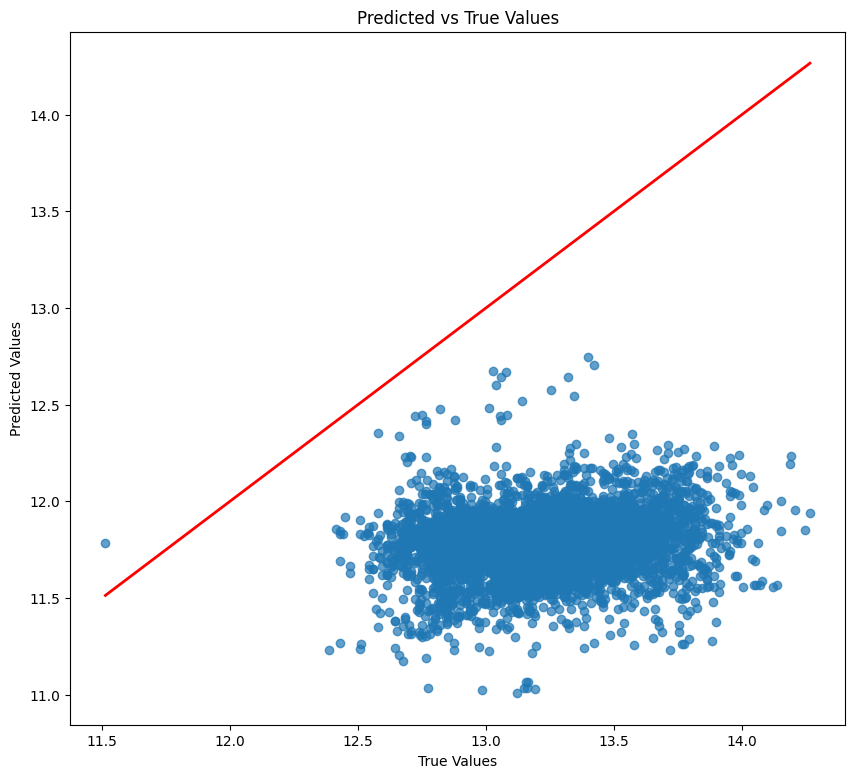

In [73]:
plt.figure(figsize=(10, 9))
plt.scatter(result['resale_price'], result['pred_result'], alpha=0.7)
plt.plot([result['resale_price'].min(), result['resale_price'].max()], [result['resale_price'].min(), result['resale_price'].max()], color='red', linewidth=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs True Values')
plt.show()

Here are some insights derived from the training results and the plot.

1. **Discrepancy in R2 Scores**: The significant difference between the Train R2 score of 0.44145 and the Test/Valid R2 scores of 0.81660 and 0.82350 respectively, suggests a potential issue with the model’s ability to generalize from the training data to unseen data. This could be indicative of an overfitting scenario where the model performs well on the validation and test sets but poorly on the training set, which is quite unusual. It’s also possible that the validation and test sets are not representative of the complexity found in the training set.

2. **Data Clustering**: The clustering of predictions around a specific range of values, particularly around 12.5 to 14.0, implies that the model may have limitations in predicting more diverse housing prices, especially for higher or lower ranges. This could mean that the model’s current architecture or feature set is not capturing the full variability in the housing prices.

3. **Underfitting Issue**: The low Train R2 score could also be a sign of underfitting, where the model is too simple to capture the underlying patterns in the training data. This might be due to the model’s complexity not being sufficient, or the features used not providing enough information for accurate predictions.

4. **Test Loss and RMSE Values**: The Test Loss of 0.01978 and RMSE of 0.14065 are relatively low, which would typically indicate good model performance. However, considering the other metrics, this may not be the case. They suggest that the model’s predictions are not far off on average, but this does not account for the distribution of errors or potential biases in predictions.

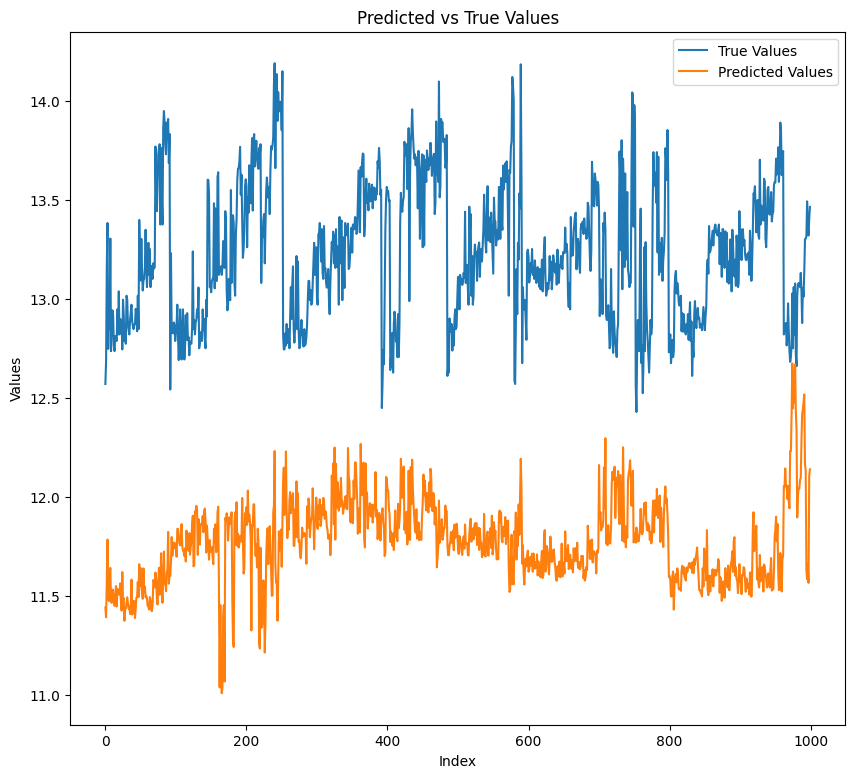

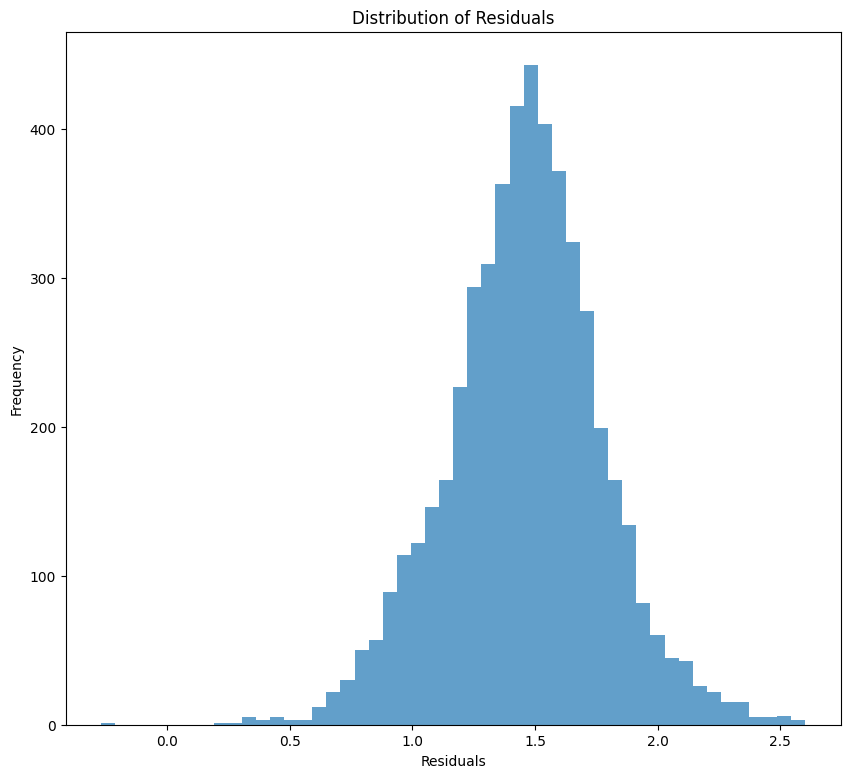

In [74]:
# plot lineplot of pred_result and resale_price for first 1000 rows
plt.figure(figsize=(10, 9))
plt.plot(result['resale_price'][:1000], label='True Values')
plt.plot(result['pred_result'][:1000], label='Predicted Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Predicted vs True Values')
plt.legend()


# plot distribution of residuals
plt.figure(figsize=(10, 9))
plt.hist(result['resale_price'] - result['pred_result'], bins=50, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

There is a high frequency (more than 450) of residuals that are 1.5. Since we did log normalisation, this would essentially mean that a large number of predictions are e^1.5=4.48 times that of the actual price. This difference can also be seen from the second predicted vs actual plot.

#### Model Evaluation

The discrepancy could be due to insufficient data points used (10k samples), but due to the lack of computing power, we are not able to increase the number of data points trained. Even though the training loss seemed to taper off after 20 epochs, the addition of more data points could tell a different story from what we are seeing now.